# Load and analyze data + some cleaning

In [25]:
!pip3 install lightgbm

    100% |████████████████████████████████| 737kB 4.6MB/s ta 0:00:01
    100% |████████████████████████████████| 12.2MB 5.2MB/s eta 0:00:01


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics

In [39]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
y = train_df["target"]


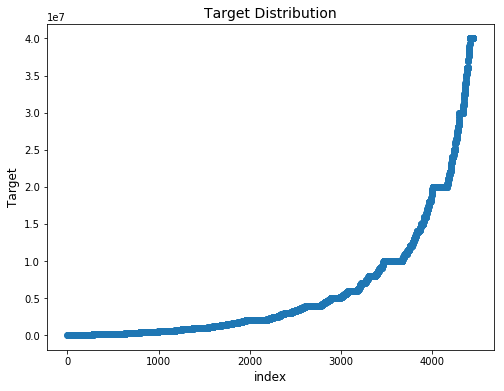

In [43]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

/home/kairat/PycharmProjects/kaggle_competitions/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


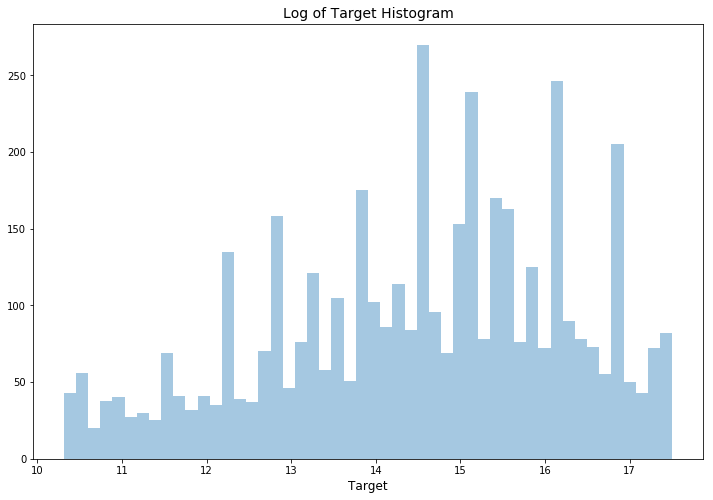

In [15]:
plt.figure(figsize=(12,8))
sns.distplot( np.log1p(train_df["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

In [44]:
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

In [61]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break

    return dups

colsToRemove = ['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']
print(colsToRemove)

['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']


In [62]:
drop_list = constant_df.col_name.tolist()
train_X = train_df.drop(labels=drop_list+colsToRemove+["target","ID"], axis = 1)
test_X = test_df.drop(labels=drop_list+colsToRemove+["ID"], axis = 1)
train_y = np.log1p(train_df["target"].values)

# LightGBM predict

In [63]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [64]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= n_splits
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44231
[400]	valid_0's rmse: 1.42178
Early stopping, best iteration is:
[380]	valid_0's rmse: 1.42093
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44249
[400]	valid_0's rmse: 1.40968
[600]	valid_0's rmse: 1.40662
Early stopping, best iteration is:
[532]	valid_0's rmse: 1.40543
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44369
[400]	valid_0's rmse: 1.41905
Early stopping, best iteration is:
[479]	valid_0's rmse: 1.41808
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.49096
[400]	valid_0's rmse: 1.45485
[600]	valid_0's rmse: 1.44857
[800]	valid_0's rmse: 1.44774
[1000]	valid_0's rmse: 1.44622
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 1.44611
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48257
[400]	valid_0's rmse:

In [65]:
# Making a submission file #
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("/tmp/baseline_lgb_full.csv", index=False)

In [66]:
pred_test_full

array([1720684.28787874, 1757135.74636376, 1569253.87933019, ...,
        849069.08530653,  715043.97673542, 1972984.68715116])

 # Normalize data

In [94]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_norm = scaler.fit_transform(train_df)
test_norm = scaler.transform(test_df)

# apply pca

In [122]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
reduced_train = pca.fit_transform(train_df)
reduced_test = pca.transform(test_df)

In [123]:
reduced_train.shape

(4459, 1221)

# Ridge loss

In [124]:
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=17)
scores = cross_val_score(ridge, reduced_train, y, n_jobs = -1, verbose=1,  scoring="neg_mean_squared_log_error")
print(np.mean(np.sqrt(-scores)))

/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/metrics/regression.py:314: RuntimeWarning: invalid value encountered in log
  return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/metrics/regression.py:314: RuntimeWarning: invalid value encountered in log
  return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/metrics/regression.py:314: RuntimeWarning: invalid value encountered in log
  return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f40e4ea78a0, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/snake/PycharmProjects/kaggle_competitions/...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/snake/PycharmProjects/kaggle_competitions/...lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/snake/.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f40e4ea78a0, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/snake/PycharmProjects/kaggle_competitions/...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/snake/PycharmProjects/kaggle_competitions/...lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/snake/.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/usr/lib/python3.5/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    340             raise RuntimeError('Event loop is running.')
    341         self._set_coroutine_wrapper(self._debug)
    342         self._thread_id = threading.get_ident()
    343         try:
    344             while True:
--> 345                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    346                 if self._stopping:
    347                     break
    348         finally:
    349             self._stopping = False

...........................................................................
/usr/lib/python3.5/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1307                         logger.warning('Executing %s took %.3f seconds',
   1308                                        _format_handle(handle), dt)
   1309                 finally:
   1310                     self._current_handle = None
   1311             else:
-> 1312                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(13, 1)>>
   1313         handle = None  # Needed to break cycles when an exception occurs.
   1314 
   1315     def _set_coroutine_wrapper(self, enabled):
   1316         try:

...........................................................................
/usr/lib/python3.5/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(13, 1)>)
    120             self._callback = None
    121             self._args = None
    122 
    123     def _run(self):
    124         try:
--> 125             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (13, 1)
    126         except Exception as exc:
    127             cb = _format_callback_source(self._callback, self._args)
    128             msg = 'Exception in callback {}'.format(cb)
    129             context = {

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=13, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 23, 14, 26, 57, 493746, tzinfo=tzutc()), 'msg_id': '36c8e0393eb24bc18bb0270333874192', 'msg_type': 'execute_request', 'session': 'cbf242742573403d9bdc524a8fcc1ae4', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '36c8e0393eb24bc18bb0270333874192', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'cbf242742573403d9bdc524a8fcc1ae4']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 23, 14, 26, 57, 493746, tzinfo=tzutc()), 'msg_id': '36c8e0393eb24bc18bb0270333874192', 'msg_type': 'execute_request', 'session': 'cbf242742573403d9bdc524a8fcc1ae4', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '36c8e0393eb24bc18bb0270333874192', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'cbf242742573403d9bdc524a8fcc1ae4'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 23, 14, 26, 57, 493746, tzinfo=tzutc()), 'msg_id': '36c8e0393eb24bc18bb0270333874192', 'msg_type': 'execute_request', 'session': 'cbf242742573403d9bdc524a8fcc1ae4', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '36c8e0393eb24bc18bb0270333874192', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.linear_model import Ridge\nridge = R...ared_log_error")\nprint(np.mean(np.sqrt(-scores)))', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-124-d14af685002f>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f409fa7b9b0, executi...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f40a0c0a4b0, file "<ipython-input-124-d14af685002f>", line 3>
        result = <ExecutionResult object at 7f409fa7b9b0, executi...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f40a0c0a4b0, file "<ipython-input-124-d14af685002f>", line 3>, result=<ExecutionResult object at 7f409fa7b9b0, executi...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f40a0c0a4b0, file "<ipython-input-124-d14af685002f>", line 3>
        self.user_global_ns = {'C': [2, 1, 0.5, 0.1], 'In': ['', 'import numpy as np\nimport pandas as pd', 'train_df = pd.read_csv("../data/train.csv")\ntest_df = pd.read_csv("../data/test.csv")', 'train_df.head()', 'train_df.shape', 'test_df.shape', 'test_df.head()', 'train_df = pd.read_csv("../data/train.csv", inde...= pd.read_csv("../data/test.csv", index_col="ID")', 'test_df.head()', 'train_df.head()', 'y = train_df[:]', 'y = train_df["target"]\ntrain_df.drop(["target"], axis=1. inplace=True)', 'y = train_df["target"]\ntrain_df.drop(["target"], axis=1, inplace=True)', 'train_df.head()', 'print(train_df.shape)\ntrain_df.head()', 'y', 'y.nunique()', 'train_df[0]', 'train_df.values()[0]', 'train_df.values[0]', ...], 'Out': {3:           ID      target  48df886f9  0deb4b6a8  ...          0          0  

[5 rows x 4993 columns], 4: (4459, 4993), 5: (49342, 4992), 6:           ID  48df886f9  0deb4b6a8  34b15f335  a...        0.0        0.0  

[5 rows x 4992 columns], 8:            48df886f9  0deb4b6a8  34b15f335  a8cb...        0.0        0.0  

[5 rows x 4991 columns], 9:                target  48df886f9  0deb4b6a8  34b...          0          0  

[5 rows x 4992 columns], 13:            48df886f9  0deb4b6a8  34b15f335  a8cb...          0          0  

[5 rows x 4991 columns], 14:            48df886f9  0deb4b6a8  34b15f335  a8cb...          0          0  

[5 rows x 4991 columns], 15: ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 4459, dtype: float64, 16: 1413, ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'Ridge': <class 'sklearn.linear_model.ridge.Ridge'>, 'SVR': <class 'sklearn.svm.classes.SVR'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, '_': array([12897.35154522, 14710.70136138, 11476.602...  9269.30800624, 11362.80565186,  7221.68147366]), '_100': array([[-0.03764565, -0.02163947, -0.04688961, .... -0.07234203,
        -0.05636327, -0.12585201]]), '_102':            48df886f9  0deb4b6a8     34b15f335  a...f6f       0.000000  

[49342 rows x 4991 columns], ...}
        self.user_ns = {'C': [2, 1, 0.5, 0.1], 'In': ['', 'import numpy as np\nimport pandas as pd', 'train_df = pd.read_csv("../data/train.csv")\ntest_df = pd.read_csv("../data/test.csv")', 'train_df.head()', 'train_df.shape', 'test_df.shape', 'test_df.head()', 'train_df = pd.read_csv("../data/train.csv", inde...= pd.read_csv("../data/test.csv", index_col="ID")', 'test_df.head()', 'train_df.head()', 'y = train_df[:]', 'y = train_df["target"]\ntrain_df.drop(["target"], axis=1. inplace=True)', 'y = train_df["target"]\ntrain_df.drop(["target"], axis=1, inplace=True)', 'train_df.head()', 'print(train_df.shape)\ntrain_df.head()', 'y', 'y.nunique()', 'train_df[0]', 'train_df.values()[0]', 'train_df.values[0]', ...], 'Out': {3:           ID      target  48df886f9  0deb4b6a8  ...          0          0  

[5 rows x 4993 columns], 4: (4459, 4993), 5: (49342, 4992), 6:           ID  48df886f9  0deb4b6a8  34b15f335  a...        0.0        0.0  

[5 rows x 4992 columns], 8:            48df886f9  0deb4b6a8  34b15f335  a8cb...        0.0        0.0  

[5 rows x 4991 columns], 9:                target  48df886f9  0deb4b6a8  34b...          0          0  

[5 rows x 4992 columns], 13:            48df886f9  0deb4b6a8  34b15f335  a8cb...          0          0  

[5 rows x 4991 columns], 14:            48df886f9  0deb4b6a8  34b15f335  a8cb...          0          0  

[5 rows x 4991 columns], 15: ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 4459, dtype: float64, 16: 1413, ...}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'Ridge': <class 'sklearn.linear_model.ridge.Ridge'>, 'SVR': <class 'sklearn.svm.classes.SVR'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, '_': array([12897.35154522, 14710.70136138, 11476.602...  9269.30800624, 11362.80565186,  7221.68147366]), '_100': array([[-0.03764565, -0.02163947, -0.04688961, .... -0.07234203,
        -0.05636327, -0.12585201]]), '_102':            48df886f9  0deb4b6a8     34b15f335  a...f6f       0.000000  

[49342 rows x 4991 columns], ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/santander/src/<ipython-input-124-d14af685002f> in <module>()
      1 from sklearn.linear_model import Ridge
      2 ridge = Ridge(random_state=17)
----> 3 scores = cross_val_score(ridge, reduced_train, y, n_jobs = -1, verbose=1,  scoring="neg_mean_squared_log_error")
      4 print(np.mean(np.sqrt(-scores)))

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001), X=array([[-1.52457370e+07, -5.50024311e+05, -3.637...57591713e+06, -9.70560076e+05, -3.05371397e+06]]), y=ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 4459, dtype: float64, groups=None, scoring='neg_mean_squared_log_error', cv=None, n_jobs=-1, verbose=1, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in cross_validate(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001), X=array([[-1.52457370e+07, -5.50024311e+05, -3.637...57591713e+06, -9.70560076e+05, -3.05371397e+06]]), y=ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 4459, dtype: float64, groups=None, scoring={'score': make_scorer(mean_squared_log_error, greater_is_better=False)}, cv=KFold(n_splits=3, random_state=None, shuffle=False), n_jobs=-1, verbose=1, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X = array([[-1.52457370e+07, -5.50024311e+05, -3.637...57591713e+06, -9.70560076e+05, -3.05371397e+06]])
        y = ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 4459, dtype: float64
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Jun 23 18:26:59 2018
PID: 5759Python 3.5.2: /home/snake/PycharmProjects/kaggle_competitions/.venv/bin/python3
...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001), memmap([[-1.52457370e+07, -5.50024311e+05, -3.63...57591713e+06, -9.70560076e+05, -3.05371397e+06]]), ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 4459, dtype: float64, {'score': make_scorer(mean_squared_log_error, greater_is_better=False)}, array([1487, 1488, 1489, ..., 4456, 4457, 4458]), array([   0,    1,    2, ..., 1484, 1485, 1486]), 1, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001), memmap([[-1.52457370e+07, -5.50024311e+05, -3.63...57591713e+06, -9.70560076e+05, -3.05371397e+06]]), ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 4459, dtype: float64, {'score': make_scorer(mean_squared_log_error, greater_is_better=False)}, array([1487, 1488, 1489, ..., 4456, 4457, 4458]), array([   0,    1,    2, ..., 1484, 1485, 1486]), 1, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001), X=memmap([[-1.52457370e+07, -5.50024311e+05, -3.63...57591713e+06, -9.70560076e+05, -3.05371397e+06]]), y=ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 4459, dtype: float64, scorer={'score': make_scorer(mean_squared_log_error, greater_is_better=False)}, train=array([1487, 1488, 1489, ..., 4456, 4457, 4458]), test=array([   0,    1,    2, ..., 1484, 1485, 1486]), verbose=1, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001)
        X_test = memmap([[-1.52457370e+07, -5.50024311e+05, -3.63...71946873e+06,  9.43111084e+05, -5.30945994e+05]])
        y_test = ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 1487, dtype: float64
        scorer = {'score': make_scorer(mean_squared_log_error, greater_is_better=False)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _score(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001), X_test=memmap([[-1.52457370e+07, -5.50024311e+05, -3.63...71946873e+06,  9.43111084e+05, -5.30945994e+05]]), y_test=ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 1487, dtype: float64, scorer={'score': make_scorer(mean_squared_log_error, greater_is_better=False)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001)
        X_test = memmap([[-1.52457370e+07, -5.50024311e+05, -3.63...71946873e+06,  9.43111084e+05, -5.30945994e+05]])
        y_test = ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 1487, dtype: float64
        scorer = {'score': make_scorer(mean_squared_log_error, greater_is_better=False)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _multimetric_score(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001), X_test=memmap([[-1.52457370e+07, -5.50024311e+05, -3.63...71946873e+06,  9.43111084e+05, -5.30945994e+05]]), y_test=ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 1487, dtype: float64, scorers={'score': make_scorer(mean_squared_log_error, greater_is_better=False)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
        estimator = Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001)
        X_test = memmap([[-1.52457370e+07, -5.50024311e+05, -3.63...71946873e+06,  9.43111084e+05, -5.30945994e+05]])
        y_test = ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 1487, dtype: float64
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(mean_squared_log_error, greater_is_better=False), estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True...False, random_state=17, solver='auto', tol=0.001), X=memmap([[-1.52457370e+07, -5.50024311e+05, -3.63...71946873e+06,  9.43111084e+05, -5.30945994e+05]]), y_true=ID
000d6aaf2    38000000.00
000fbd867      60000...000.00
Name: target, Length: 1487, dtype: float64, sample_weight=None)
    103             return self._sign * self._score_func(y_true, y_pred,
    104                                                  sample_weight=sample_weight,
    105                                                  **self._kwargs)
    106         else:
    107             return self._sign * self._score_func(y_true, y_pred,
--> 108                                                  **self._kwargs)
        self._kwargs = {}
    109 
    110 
    111 class _ProbaScorer(_BaseScorer):
    112     def __call__(self, clf, X, y, sample_weight=None):

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/metrics/regression.py in mean_squared_log_error(y_true=array([[38000000.],
       [  600000.],
       [...00000.],
       [ 6000000.],
       [  922000.]]), y_pred=array([[  9008546.15738128],
       [  6759237.4... 6826125.46616534],
       [-25818253.49610107]]), sample_weight=None, multioutput='uniform_average')
    310     if not (y_true >= 0).all() and not (y_pred >= 0).all():
    311         raise ValueError("Mean Squared Logarithmic Error cannot be used when "
    312                          "targets contain negative values.")
    313 
    314     return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),
--> 315                               sample_weight, multioutput)
        sample_weight = None
        multioutput = 'uniform_average'
    316 
    317 
    318 def median_absolute_error(y_true, y_pred):
    319     """Median absolute error regression loss

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/metrics/regression.py in mean_squared_error(y_true=array([[17.45309674],
       [13.3046866 ],
    ...18],
       [15.60727019],
       [13.73430159]]), y_pred=array([[16.01368437],
       [15.72642079],
    ...99],
       [15.73626794],
       [        nan]]), sample_weight=None, multioutput='uniform_average')
    233     ... # doctest: +ELLIPSIS
    234     0.824...
    235 
    236     """
    237     y_type, y_true, y_pred, multioutput = _check_reg_targets(
--> 238         y_true, y_pred, multioutput)
        y_true = array([[17.45309674],
       [13.3046866 ],
    ...18],
       [15.60727019],
       [13.73430159]])
        y_pred = array([[16.01368437],
       [15.72642079],
    ...99],
       [15.73626794],
       [        nan]])
        multioutput = 'uniform_average'
    239     output_errors = np.average((y_true - y_pred) ** 2, axis=0,
    240                                weights=sample_weight)
    241     if isinstance(multioutput, string_types):
    242         if multioutput == 'raw_values':

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/metrics/regression.py in _check_reg_targets(y_true=array([[17.45309674],
       [13.3046866 ],
    ...18],
       [15.60727019],
       [13.73430159]]), y_pred=array([[16.01368437],
       [15.72642079],
    ...99],
       [15.73626794],
       [        nan]]), multioutput='uniform_average')
     72         correct keyword.
     73 
     74     """
     75     check_consistent_length(y_true, y_pred)
     76     y_true = check_array(y_true, ensure_2d=False)
---> 77     y_pred = check_array(y_pred, ensure_2d=False)
        y_pred = array([[16.01368437],
       [15.72642079],
    ...99],
       [15.73626794],
       [        nan]])
     78 
     79     if y_true.ndim == 1:
     80         y_true = y_true.reshape((-1, 1))
     81 

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/utils/validation.py in check_array(array=array([[16.01368437],
       [15.72642079],
    ...99],
       [15.73626794],
       [        nan]]), accept_sparse=False, dtype=None, order=None, copy=False, force_all_finite=True, ensure_2d=False, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    448             array = array.astype(np.float64)
    449         if not allow_nd and array.ndim >= 3:
    450             raise ValueError("Found array with dim %d. %s expected <= 2."
    451                              % (array.ndim, estimator_name))
    452         if force_all_finite:
--> 453             _assert_all_finite(array)
        array = array([[16.01368437],
       [15.72642079],
    ...99],
       [15.73626794],
       [        nan]])
    454 
    455     shape_repr = _shape_repr(array.shape)
    456     if ensure_min_samples > 0:
    457         n_samples = _num_samples(array)

...........................................................................
/home/snake/PycharmProjects/kaggle_competitions/.venv/lib/python3.5/site-packages/sklearn/utils/validation.py in _assert_all_finite(X=array([[16.01368437],
       [15.72642079],
    ...99],
       [15.73626794],
       [        nan]]))
     39     # everything is finite; fall back to O(n) space np.isfinite to prevent
     40     # false positives from overflow in sum method.
     41     if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
     42             and not np.isfinite(X).all()):
     43         raise ValueError("Input contains NaN, infinity"
---> 44                          " or a value too large for %r." % X.dtype)
        X.dtype = dtype('float64')
     45 
     46 
     47 def assert_all_finite(X):
     48     """Throw a ValueError if X contains NaN or infinity.

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
___________________________________________________________________________

# SVM CV

In [119]:
%%time
svm_clf = SVR(C=c, epsilon=e,cache_size=10000, verbose=True)
scores = cross_val_score(svm_clf, reduced_train, y, n_jobs = -1, verbose=1,  scoring="neg_mean_squared_log_error")
print(np.mean(np.sqrt(-scores)))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s finished


1.7576713977612872
CPU times: user 192 ms, sys: 472 ms, total: 664 ms
Wall time: 13.8 s


In [118]:
np.mean(np.sqrt(-scores))

1.7576704987912395

In [129]:
from sklearn.svm import SVR
svm_clf_pca = SVR(C=1.0, epsilon=0.2,cache_size=10000, verbose=True)
svm_clf_pca.fit(reduced_train, y)

[LibSVM]

SVR(C=1.0, cache_size=10000, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [131]:
pca_preds = svm_clf_pca.predict(reduced_test)

# SVM solution

In [128]:
%%time
from sklearn.svm import SVR
svm_clf_final = SVR(C=1.0, epsilon=0.2,cache_size=10000, verbose=True)
svm_clf_final.fit(train_norm, y)

[LibSVM]CPU times: user 2min 18s, sys: 216 ms, total: 2min 18s
Wall time: 2min 19s


In [96]:
%%time
svm_preds = svm_clf_final.predict(test_norm)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

# Combining solutions

In [134]:
final_preds = (svm_preds+pca_preds)/2.0
def prepare_score_file(scores):
    test_item_id = test_df.index
    sub_df = pd.DataFrame({"ID":test_item_id})
    sub_df["target"] = scores
    sub_df.to_csv("/tmp/santander.csv", index=False)
prepare_score_file(final_preds)